# MIRAC-5 Reduce Helper

This jupyter notebook is intended to both provide instructions on how to use the mirac5reduce package and serve as a simple user interface for performing their own simple reductions.


## Set Up the Config File

First, you will want to create your own copy of the config file and edit it. 

The sample config file is provided as part of the mirac5reduce package under `docs/runparams.init`. 

Create a copy of that file, preferably somewhere near where your reduction files will be, though that isn't required. 

Enter the path and file name of this copy in the following cell to save it as the variable, `config_file`:

In [1]:
config_file = ''

Open your config file in your text editor of choice. You will see that it has 4 sections: `[REDUCTION]`, `[CALIB]`, `[COMPUTING]`, and `[DATA_ARCH]`.

The last two sections, `[COMPUTING]` and `[DATA_ARCH]` contain parameters that are specific to the computer that you are running the reduction on and the architecture of the data produced by the MIRAC-5 data aqcuisition software, respectively. 

**Review and set the parameters in the `[COMPUTING]` and `[DATA_ARCH]` sections of your config file.** They should not change for the rest of the reduction. Descriptions are provided in the template config file. 

The remaining sections, `[REDUCTION]` and `[CALIB]` contain parameters that can either be provided directly when calling a function or imported from this config file to simplify function calls.

To aid in flexibility, this notebook will allow most of the parameters to be provided directly on function calls. But we do assume that (1) all raw data is stored in the same path and (2) all raw calibration files are stored in the same path. (These paths may be the same or different.)

**Review and set the following parameters in your config file:**
* `raw_data_path` in the `[REDUCTION]` section
* `raw_cals_path` in the `[CALIB]` section

**Make sure all other keyword values in these two sections are empty and save your config file.**


## Set Up Python Environment

Briefly, we import the scripts that contain the main upper-level functions:

In [2]:
from mirac5reduce.reduce import combine_frames
from mirac5reduce.cal import bpmask

In addition, all of the upper-level functions in `mirac5reduce` have the option to write output to a log file instead of printing it to the terminal. Use the cell below to set your log file or update it if you decide to start a new one:

In [3]:
# To write output to a log file, uncomment the line below and fill in the path and file name for the log file
# logfile = ''
# Or, to just write output directly to terminal, uncomment the following line instead
# logfile = None

Finally, import a few side-packages that will help with visualization in this notebook:

In [23]:
from astropy.io import fits
from matplotlib import pyplot as P
import numpy as np
from mirac5reduce.utils.statfunc import medabsdev

## Calculate Mean Dark File

The function, `combine_frames.meanframe` calculates the mean frame for a range of file numbers and saves the output to a fits file with a populated header. While this function is general, it determines which raw file path to use from the config file from the data type specified when calling it.

In [5]:
# Enter the start and end file numbers (inclusive) of the range of raw dark files that you want to average
raw_dark_startno = 10
raw_dark_endno   = 19

# Enter the path and (FITS) file name of the mean dark fits file that you want to create
mean_dark_filename = ''

# Then run meanframe
combine_frames.meanframe( config_file, 'dark', logfile = logfile, 
                          startno = raw_dark_startno, endno = raw_dark_endno, outfile = mean_dark_filename )

Use this cell to preview this file and its header:

Mean Value: 5.01e-01 DN
Median Value: 5.02e-01 DN
Std Dev: 1.59e-01 DN
Med. Abs. Dev.: 1.59e-01 DN


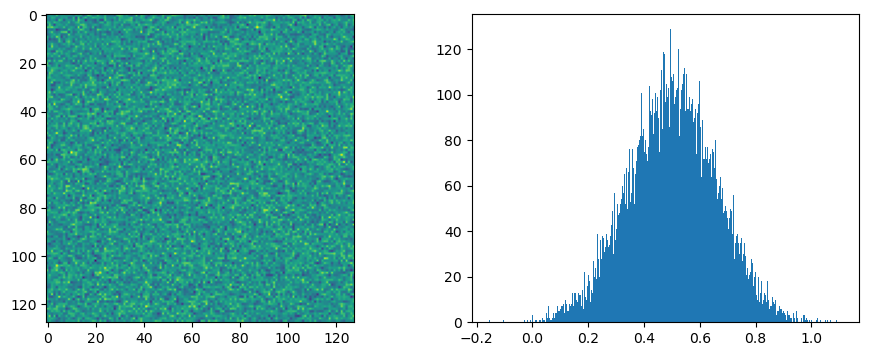

In [24]:
## Run for file preview only; no editing needed ##
with fits.open( mean_dark_filename ) as hdulist:
    
    print('Mean Value: {0:.2e} DN'.format( np.mean(hdulist[0].data) ))
    print('Median Value: {0:.2e} DN'.format( np.median(hdulist[0].data) ))
    print('Std Dev: {0:.2e} DN'.format( np.std(hdulist[0].data) ))
    print('Med. Abs. Dev.: {0:.2e} DN'.format( medabsdev(hdulist[0].data) ))
    
    fig, axes = P.subplots(figsize = (11,4),  ncols=2)
    axes[0].imshow( hdulist[0].data )
    axes[1].hist(hdulist[0].data.ravel(), bins=500)

## Create Bad Pixel Mask

The bad pixel mask is created with a simple sigma-filter on the median absolute deviation of the mean dark file created above.

In [25]:
# Uses the same mean_dark_filename as above

# The threshold above and below which pixels are considered bad is 
#     this number x the M.A.D. on either side of the median
bp_threshold = 7.0

# The path and (FITS) file name to which the bad pixel mask will be saved
bp_filename = ''

# Then create and save the bad pixel mask
bpmask.make_bpmask( config_file, logfile = logfile, 
                    dark_file = mean_dark_filename, bp_threshold = bp_threshold, outfile = bp_filename )

While the histogram from the mean dark file above may provide more insight, the cell below can be used for a basic summary of the mask data.

In [27]:
## Run cell for file preview only; no editing needed ##
with fits.open( bp_filename ) as hdulist:
    
    print('Flagged {0} / {1} pixels ({2:.1f}%)'.format( np.sum(hdulist[0].data), hdulist[0].data.size, 
                                                       100. * np.sum(hdulist[0].data) / hdulist[0].data.size ))
    print('\nSelected Values from Header:')
    for key in ['FILETYPE','DARKFILE','NFRAMES','FILE_STR','FILE_END','COMBTYPE']:
        print( '{0: <8} = {1: >16} / {2}'.format( *hdulist[0].header.cards[key] ) )
    

Flagged 0 / 16384 pixels (0.0%)

Values from Header:
FILETYPE =       Pixel Mask / 
DARKFILE =    meandark.fits / Dark file used
NFRAMES  =               10 / Number raw frames in darkfile
FILE_STR =  gsnapImg10.fits / First raw file in darkfile
FILE_END =  gsnapImg19.fits / Last raw file in darkfile
COMBTYPE =             MEAN / How darkfile frames were combined


## Create Mean Flat File

Just as with the mean dark file, the `combine_frames.meanframe` function can be used to create a mean flat frame instead of a mean dark frame.

In [ ]:
# Enter the start and end file numbers (inclusive) of the range of raw flat files that you want to average
raw_flat_startno = 10
raw_flat_endno   = 19

# Enter the path and (FITS) file name of the mean flat fits file that you want to create
mean_flat_filename = ''

# Then run meanframe
combine_frames.meanframe( config_file, 'flat', logfile = logfile, 
                          startno = raw_flat_startno, endno = raw_flat_endno, outfile = mean_flat_filename )

Again, the cell below just offers a preview of the contents of the created file:

In [ ]:
## Run for file preview only; no editing needed ##
with fits.open( mean_flat_filename ) as hdulist:
    
    print('Mean Value: {0:.2e} DN'.format( np.mean(hdulist[0].data) ))
    print('Median Value: {0:.2e} DN'.format( np.median(hdulist[0].data) ))
    print('Std Dev: {0:.2e} DN'.format( np.std(hdulist[0].data) ))
    print('Med. Abs. Dev.: {0:.2e} DN'.format( medabsdev(hdulist[0].data) ))
    
    fig, axes = P.subplots(figsize = (11,4),  ncols=2)
    axes[0].imshow( hdulist[0].data )
    axes[1].hist(hdulist[0].data.ravel(), bins=500)

## Observation Reduction

To allow reduction of observations taken in chop/nod mode or staring mode, this section of the notebook is split based on mode, below.

### Chop/Nod Reduction

Reduction of the chop nod data is currently limited to calculating the mean difference frame of all of the chop/nodded frames with `combine_frames.chopnodframe`.

It can be ran with the following:

In [33]:
# Enter the start and end file numbers (inclusive) of the range of raw chop/nod files that you want to average
raw_data_startno = 100
raw_data_endno   = 147

# Set the chop and nod frequencies, in Hz
chopfreq = 42.5
nodfreq  = 7.083333333333333

# Enter the path and (FITS) file name of the resulting mean chop/nod diff fits file that you want to create
chopnod_filename = ''

# Then run chopnodframe
combine_frames.chopnodframe( config_file, logfile = logfile,
                             startno = raw_data_startno, endno = raw_data_endno,
                             chopfreq = chopfreq, nodfreq = nodfreq, outfile = chopnod_filename )

The cell below provides a preview, with optional masking:

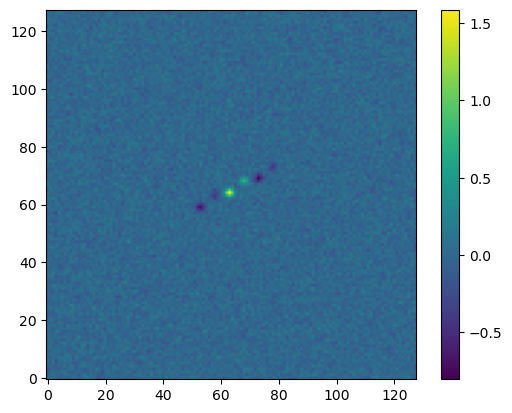

In [34]:
# Set bool specifying whether you want to apply bad pixel mask created above to the plotted figures
plot_with_mask = False

## Run for image preview only; no editing needed ##
cn_data = fits.getdata( chopnod_filename, 0 )

if plot_with_mask:
    mask = fits.getdata( bp_filename, 0 )
    cn_data = np.ma.masked_array( cn_data, mask=mask )
    cn_data = cn_data.filled( np.nan )

P.imshow( cn_data, origin='lower' )
P.colorbar()

If you know the chop/nod throw, in pixels, you can recombine the image here:

(52.0, 68.0)

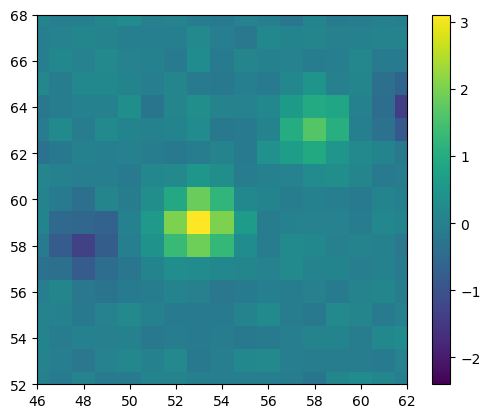

In [40]:
# Assumes parallel chop/nod throws, where chop-1-nod-A and chop-2-nod-B are at the same location. 
# Specify the throw of one of the two negative chop/nod positions with respect 1A/2B position as [dx, dy], in pix, 
#    where a positive dx value indicates that the negative source imprint is to the right of the positive source
#    The other negative imprint will be assumed to be the opposite direction from the positive central source
offset = [ 10, 5 ]

# combines frames, but does *not* trim around the positive source
frame_dy = cn_data.shape[0] - abs( 2*offset[1] )
frame_dx = cn_data.shape[1] - abs( 2*offset[0] )
x0 = abs(offset[0]); y0 = abs(offset[1])
recomb_frame =   cn_data[ y0 : frame_dy+y0, x0 : frame_dx+x0 ] - \
                 cn_data[ y0+offset[1] : frame_dy+y0+offset[1], x0+offset[0] : frame_dx+x0+offset[0] ] - \
                 cn_data[ y0-offset[1] : frame_dy+y0-offset[1], x0-offset[0] : frame_dx+x0-offset[0] ]

# Plots recombined frame
P.imshow( recomb_frame ); P.colorbar()

# Use this line to zoom into where your source is in the image
P.xlim(46,62); P.ylim(52,68)

## Staring Mode Observations

(under development)